# Анализ динамики диска на аэростоле

**Данные:** акселерометр + гироскоп (чип на диске), 50 Гц, 20 с записи  
**Установка:** диск плавает на воздушной подушке по поверхности аэростола. По краям натянуты струны, обеспечивающие упругое столкновение диска с краями.

**Цель:** извлечь количественные характеристики:
1. Модель вращательного трения (затухание угловой скорости между столкновениями)
2. Параметры столкновений со струнами (тангенциальный импульс, потери энергии)
3. Динамика поступательного движения (через интервалы между столкновениями)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams.update({
    'figure.figsize': (12, 4),
    'figure.dpi': 120,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
})


## 1. Загрузка и обзор данных

In [2]:
df = pd.read_csv('4.csv')
print(f"Размер: {df.shape[0]} отсчётов, dt = {np.median(np.diff(df['time_s'])):.3f} с (50 Гц)")
print(f"Длительность записи: {df['time_s'].iloc[-1]:.1f} с")
print(f"\nСтолбцы: {list(df.columns)}")
print(f"  ax, ay, az — ускорения в единицах g")
print(f"  gx, gy, gz — угловые скорости в °/с")
df.head(10)


Размер: 1000 отсчётов, dt = 0.020 с (50 Гц)
Длительность записи: 20.0 с

Столбцы: ['time_s', 'ax_g', 'ay_g', 'az_g', 'gx_dps', 'gy_dps', 'gz_dps']
  ax, ay, az — ускорения в единицах g
  gx, gy, gz — угловые скорости в °/с


,time_s,ax_g,ay_g,az_g,gx_dps,gy_dps,gz_dps
0,0.00,0.031720,0.007808,-0.976488,1.33,-2.94,0.42
1,0.02,0.029768,0.007808,-0.973560,1.68,-3.01,0.42
2,0.04,0.034648,0.008784,-0.977464,1.54,-3.08,0.14
3,0.06,0.033672,0.005856,-0.982344,1.75,-3.22,0.00
4,0.08,0.032696,0.002440,-0.975512,1.40,-2.94,-0.14
5,0.10,0.034160,-0.001464,-0.981856,1.47,-2.80,-2.45
6,0.12,0.036112,-0.006344,-0.984296,2.03,-3.01,-5.39
7,0.14,0.084912,-0.100528,-0.979416,3.29,-2.38,-6.58
8,0.16,0.005368,0.042944,-0.982832,0.14,-3.29,-4.13
9,0.18,0.027328,-0.051728,-0.977464,3.15,-2.24,-23.10


## 2. Обзорные графики

<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_113/3241147280.py:18: SyntaxWarning: invalid escape sequence '\o'
  axes[2].set_ylabel('$\omega_z$, °/с')


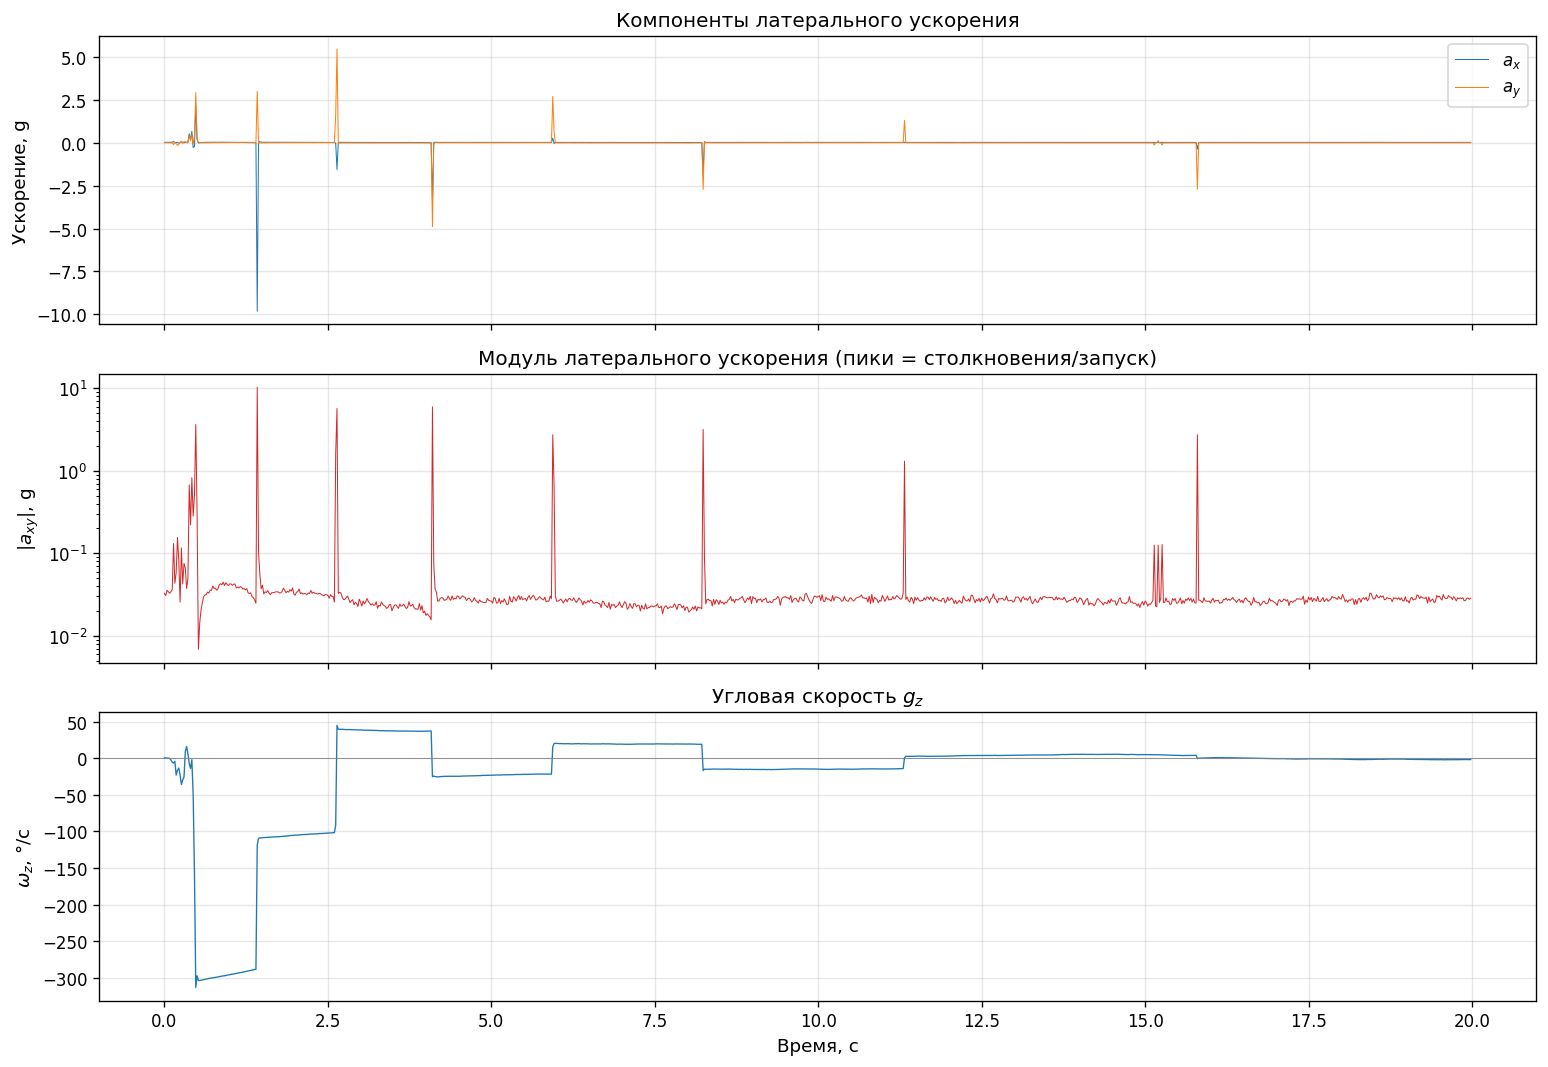

In [3]:
# Латеральное ускорение (в плоскости стола)
df['a_xy'] = np.sqrt(df['ax_g']**2 + df['ay_g']**2)

fig, axes = plt.subplots(3, 1, figsize=(13, 9), sharex=True)

axes[0].plot(df['time_s'], df['ax_g'], lw=0.6, label='$a_x$')
axes[0].plot(df['time_s'], df['ay_g'], lw=0.6, label='$a_y$')
axes[0].set_ylabel('Ускорение, g')
axes[0].set_title('Компоненты латерального ускорения')
axes[0].legend()

axes[1].plot(df['time_s'], df['a_xy'], lw=0.6, color='C3')
axes[1].set_ylabel('$|a_{xy}|$, g')
axes[1].set_title('Модуль латерального ускорения (пики = столкновения/запуск)')
axes[1].set_yscale('log')

axes[2].plot(df['time_s'], df['gz_dps'], lw=0.8, color='C0')
axes[2].set_ylabel('$\omega_z$, °/с')
axes[2].set_xlabel('Время, с')
axes[2].set_title('Угловая скорость $g_z$')
axes[2].axhline(0, color='gray', lw=0.5)

plt.tight_layout()
plt.show()


**Наблюдения:**
- Пики $|a_{xy}|$ — моменты столкновений (и один запуск рукой).
- $\omega_z$ имеет скачки при столкновениях и плавно затухает между ними.
- Знак $\omega_z$ меняется при большинстве столкновений — тангенциальный импульс от струны.


## 3. Детекция столкновений

In [4]:
def detect_collisions(df, threshold=0.5, merge_gap=3):
    """Находит группы отсчётов, где |a_xy| > threshold, 
    объединяя соседние (gap <= merge_gap отсчётов)."""
    mask = df['a_xy'] > threshold
    indices = df.index[mask].tolist()
    if not indices:
        return []
    groups = [[indices[0]]]
    for i in range(1, len(indices)):
        if indices[i] - indices[i-1] <= merge_gap:
            groups[-1].append(indices[i])
        else:
            groups.append([indices[i]])
    return groups

all_events = detect_collisions(df, threshold=0.5)
print(f"Обнаружено {len(all_events)} событий (|a_xy| > 0.5 g)")

# Первое событие — запуск рукой, исключаем
launch_event = all_events[0]
collisions = all_events[1:]
print(f"  Событие #1 (t ≈ {df.loc[launch_event[0], 'time_s']:.2f} с) — запуск рукой, исключён")
print(f"  Столкновений со струнами: {len(collisions)}")


Обнаружено 8 событий (|a_xy| > 0.5 g)
  Событие #1 (t ≈ 0.38 с) — запуск рукой, исключён
  Столкновений со струнами: 7


<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_113/2597509293.py:2: SyntaxWarning: invalid escape sequence '\o'
  ax.plot(df['time_s'], df['gz_dps'], lw=0.8, color='C0', label='$\omega_z$')
/tmp/ipykernel_113/2597509293.py:17: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('$\omega_z$, °/с')


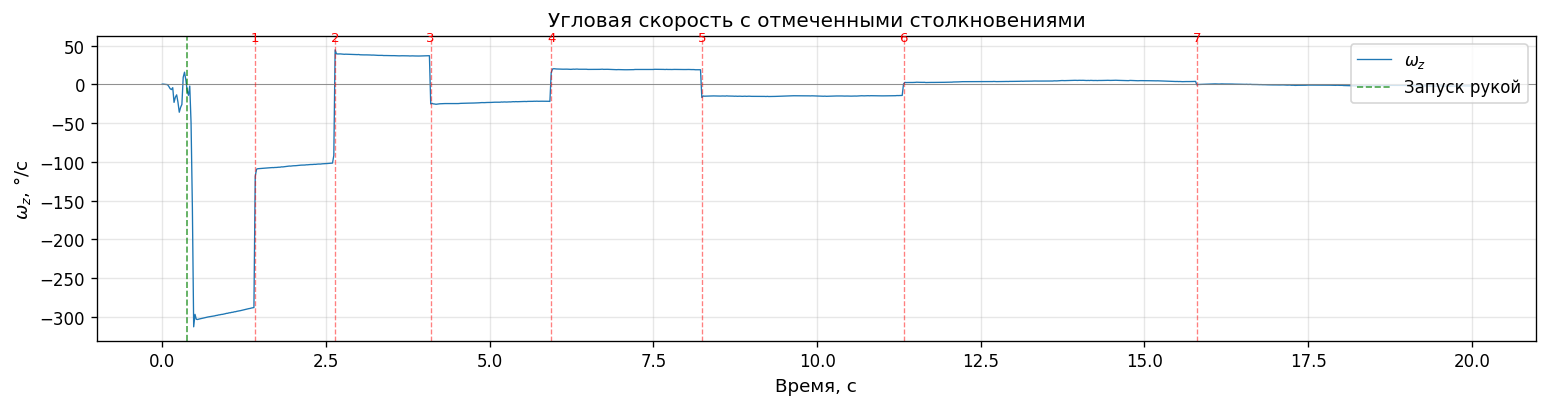

In [5]:
fig, ax = plt.subplots(figsize=(13, 3.5))
ax.plot(df['time_s'], df['gz_dps'], lw=0.8, color='C0', label='$\omega_z$')
ax.axhline(0, color='gray', lw=0.5)

# Отметим запуск
launch_t = df.loc[launch_event[0], 'time_s']
ax.axvline(launch_t, color='green', ls='--', lw=1, alpha=0.7, label='Запуск рукой')

# Отметим столкновения
for i, grp in enumerate(collisions):
    peak_idx = df.loc[grp, 'a_xy'].idxmax()
    t = df.loc[peak_idx, 'time_s']
    ax.axvline(t, color='red', ls='--', lw=0.8, alpha=0.5)
    ax.text(t, ax.get_ylim()[1]*0.9, f'{i+1}', ha='center', fontsize=8, color='red')

ax.set_xlabel('Время, с')
ax.set_ylabel('$\omega_z$, °/с')
ax.set_title('Угловая скорость с отмеченными столкновениями')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


## 4. Параметры столкновений

In [6]:
def get_collision_params(df, collisions, n_avg=10):
    """Извлекает параметры каждого столкновения."""
    results = []
    for i, grp in enumerate(collisions):
        # Пиковое ускорение
        peak_idx = df.loc[grp, 'a_xy'].idxmax()
        peak_a = df.loc[peak_idx, 'a_xy']
        peak_t = df.loc[peak_idx, 'time_s']
        ax_peak = df.loc[peak_idx, 'ax_g']
        ay_peak = df.loc[peak_idx, 'ay_g']
        theta = np.degrees(np.arctan2(ay_peak, ax_peak))
        
        # ω до и после (среднее по n_avg точкам)
        b_start = max(0, grp[0] - n_avg)
        b_end = grp[0] - 1
        a_start = grp[-1] + 2
        a_end = min(len(df)-1, grp[-1] + n_avg)
        
        gz_before = np.mean(df.loc[b_start:b_end, 'gz_dps']) if b_end >= b_start else np.nan
        gz_after = np.mean(df.loc[a_start:a_end, 'gz_dps']) if a_end >= a_start else np.nan
        
        delta_gz = gz_after - gz_before
        sign_change = np.sign(gz_before) != np.sign(gz_after)
        
        # Отношение ω²
        ke_ratio = (gz_after/gz_before)**2 if abs(gz_before) > 0.5 else np.nan
        
        results.append({
            '#': i+1, 't, с': round(peak_t, 3),
            '|a|, g': round(peak_a, 2),
            'θ, °': round(theta, 1),
            'ω_до, °/с': round(gz_before, 1),
            'ω_после, °/с': round(gz_after, 1),
            'Δω, °/с': round(delta_gz, 1),
            'Смена знака': '✓' if sign_change else '',
            'ω²_после/ω²_до': round(ke_ratio, 3) if not np.isnan(ke_ratio) else '—',
        })
    return pd.DataFrame(results)

params = get_collision_params(df, collisions)
params


,#,"t, с","|a|, g","θ, °","ω_до, °/с","ω_после, °/с","Δω, °/с",Смена знака,ω²_после/ω²_до
0,1,1.42,10.27,163.0,-289.8,-108.3,181.5,,0.140
1,2,2.64,5.69,105.9,-102.1,39.2,141.4,✓,0.148
2,3,4.10,5.95,-124.7,36.9,-25.1,-62.0,✓,0.461
3,4,5.94,2.72,84.3,-21.6,19.9,41.5,✓,0.844
4,5,8.24,3.17,-121.1,19.2,-14.9,-34.0,✓,0.602
5,6,11.32,1.31,89.1,-14.4,2.6,17.0,✓,0.033
6,7,15.80,2.73,-97.6,3.8,0.4,-3.4,,0.011


**Ключевые наблюдения:**
- В 5 из 7 столкновений **знак ω меняется** — тангенциальная составляющая импульса разворачивает вращение.
- Направления ударов ($\theta$) чередуются между ~90° и ~−120° — диск отскакивает между двумя противоположными струнами.
- Потери вращательной КЭ ($1 - \omega^2_{после}/\omega^2_{до}$) варьируются от 16% до 98%.


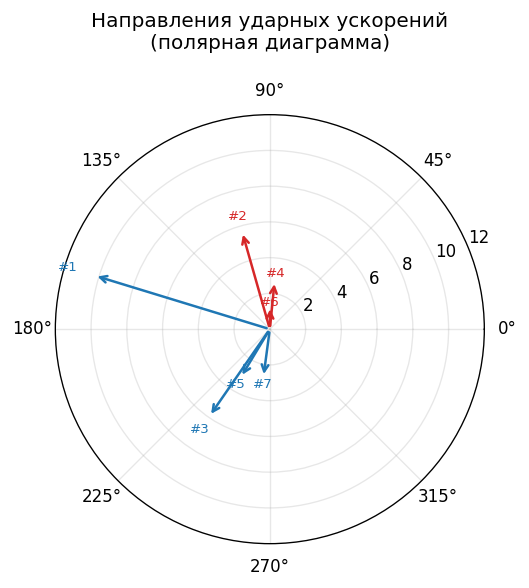

In [7]:
fig, ax = plt.subplots(figsize=(6, 5), subplot_kw={'projection': 'polar'})

for i, grp in enumerate(collisions):
    peak_idx = df.loc[grp, 'a_xy'].idxmax()
    ax_p = df.loc[peak_idx, 'ax_g']
    ay_p = df.loc[peak_idx, 'ay_g']
    a_mag = np.sqrt(ax_p**2 + ay_p**2)
    theta = np.arctan2(ay_p, ax_p)
    
    color = 'C0' if i % 2 == 0 else 'C3'
    ax.annotate('', xy=(theta, a_mag), xytext=(0, 0),
                arrowprops=dict(arrowstyle='->', color=color, lw=1.5))
    ax.text(theta, a_mag * 1.15, f'#{i+1}', ha='center', va='center', fontsize=8, color=color)

ax.set_title('Направления ударных ускорений\n(полярная диаграмма)', pad=20)
ax.set_rmax(12)
plt.tight_layout()
plt.show()


## 5. Модель вращательного трения

Между столкновениями диск вращается, испытывая только трение о воздух.
Рассмотрим две модели:
- **Вязкое трение:** $\alpha = -k_{\text{visc}} \cdot \omega \;\Rightarrow\; \omega(t) = \omega_0 \, e^{-t/\tau}$, где $\tau = 1/k_{\text{visc}}$
- **Кулоновское трение:** $\alpha = -k_{\text{Coul}} \cdot \text{sign}(\omega)$, т.е. постоянное замедление

Измерим $|\alpha|$ и $|\omega|$ на каждом «тихом» сегменте через линейную аппроксимацию $\omega(t)$.


In [8]:
def get_quiet_segments(df, launch_event, collisions, margin=5, min_len=15):
    """Извлекает тихие сегменты между событиями."""
    segments = []
    
    # Сегмент после запуска, до первого столкновения
    s0_start = launch_event[-1] + margin
    s0_end = collisions[0][0] - margin
    if s0_end - s0_start >= min_len:
        segments.append(('После запуска', s0_start, s0_end))
    
    # Сегменты между столкновениями
    for i in range(len(collisions)):
        start = collisions[i][-1] + margin
        end = collisions[i+1][0] - margin if i < len(collisions)-1 else len(df)-1
        if end - start >= min_len:
            segments.append((f'После C{i+1}', start, end))
    
    return segments

segments = get_quiet_segments(df, launch_event, collisions)

omega_abs_list = []
alpha_abs_list = []
seg_labels = []

print(f"{'Сегмент':<18} {'Время':>14} {'⟨ω⟩, °/с':>12} {'α, °/с²':>12} {'|ω|':>8} {'|α|':>8}")
print('-' * 76)

for label, i_start, i_end in segments:
    seg = df.iloc[i_start:i_end+1]
    t = seg['time_s'].values
    gz = seg['gz_dps'].values
    
    coeffs = np.polyfit(t, gz, 1)
    slope = coeffs[0]  # °/с²
    gz_mean = np.mean(gz)
    
    print(f"{label:<18} {t[0]:6.2f}–{t[-1]:5.2f} с {gz_mean:>11.1f} {slope:>11.2f} {abs(gz_mean):>7.1f} {abs(slope):>7.2f}")
    
    if abs(gz_mean) > 3:
        omega_abs_list.append(abs(gz_mean))
        alpha_abs_list.append(abs(slope))
        seg_labels.append(label)

omega_arr = np.array(omega_abs_list)
alpha_arr = np.array(alpha_abs_list)


Сегмент                     Время     ⟨ω⟩, °/с      α, °/с²      |ω|      |α|
----------------------------------------------------------------------------
После запуска        0.58– 1.32 с      -296.2       17.12   296.2   17.12
После C1             1.52– 2.52 с      -105.1        6.49   105.1    6.49
После C2             2.74– 4.00 с        37.7       -2.07    37.7    2.07
После C3             4.20– 5.84 с       -23.2        2.31    23.2    2.31
После C4             6.06– 8.14 с        19.5       -0.21    19.5    0.21
После C5             8.34–11.22 с       -14.9        0.17    14.9    0.17
После C6            11.42–15.70 с         4.2        0.50     4.2    0.50
После C7            15.90–19.98 с        -1.0       -0.67     1.0    0.67


Линейный фит: |α| = 0.05841 · |ω| + (-0.054)
  Вязкий коэффициент:  k = 0.05841 с⁻¹
  Постоянная времени:  τ = 1/k = 17.1 с
  Кулоновская добавка: -0.054 °/с² (пренебрежимо мала)

  ➜ Модель: чисто вязкое трение, ω(t) = ω₀ · exp(−t/17.1)


<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:26: SyntaxWarning: invalid escape sequence '\o'
<>:48: SyntaxWarning: invalid escape sequence '\o'
<>:50: SyntaxWarning: invalid escape sequence '\o'
<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:26: SyntaxWarning: invalid escape sequence '\o'
<>:48: SyntaxWarning: invalid escape sequence '\o'
<>:50: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_113/3219825287.py:25: SyntaxWarning: invalid escape sequence '\c'
  label=f'$|\\alpha| = {k_visc:.4f} \cdot |\omega|$')
/tmp/ipykernel_113/3219825287.py:26: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('$|\omega|$, °/с')
/tmp/ipykernel_113/3219825287.py:48: SyntaxWarning: invalid escape sequence '\o'
  label=f'$\omega_0 \cdot e^{{-t/\\tau}}$, τ = {popt[1]:.1f} с')
/tmp/ipykernel_113/3219825287.py:50: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('$\omega_z$, °/с')


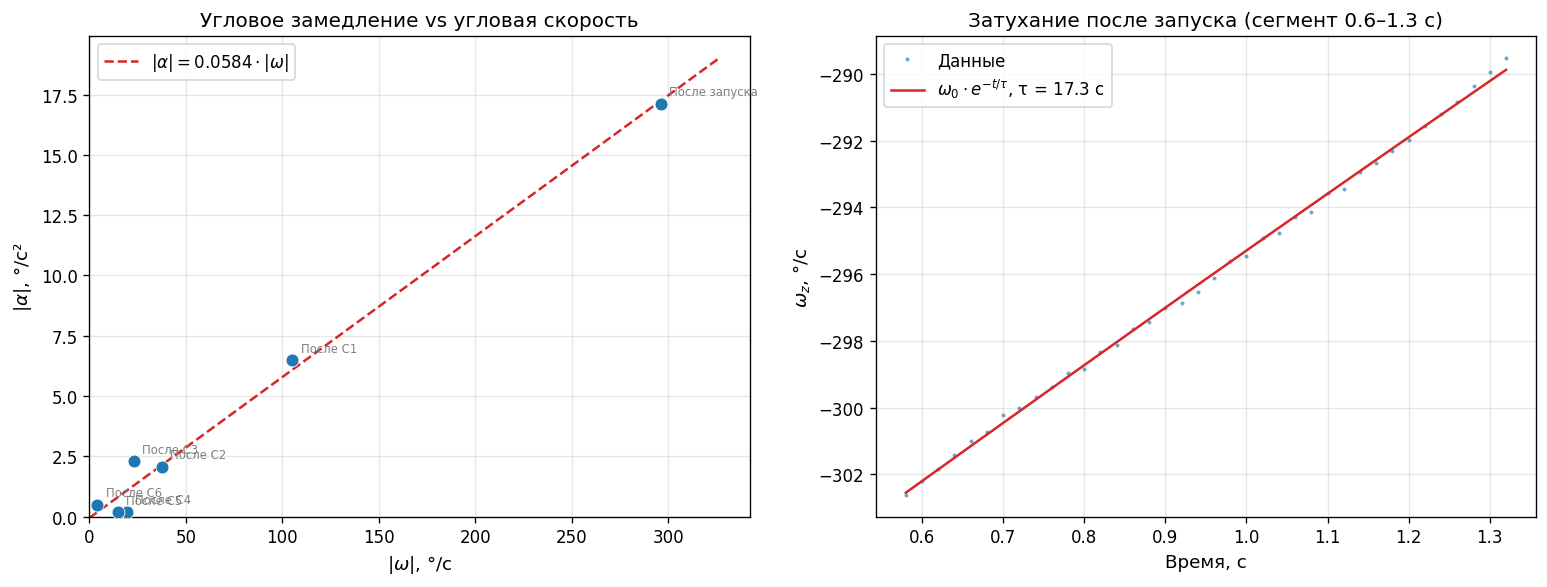

In [9]:
# Линейная аппроксимация: |α| = k * |ω| + b
coeffs_fit = np.polyfit(omega_arr, alpha_arr, 1)
k_visc = coeffs_fit[0]
k_coul = coeffs_fit[1]

print(f"Линейный фит: |α| = {k_visc:.5f} · |ω| + ({k_coul:.3f})")
print(f"  Вязкий коэффициент:  k = {k_visc:.5f} с⁻¹")
print(f"  Постоянная времени:  τ = 1/k = {1/k_visc:.1f} с")
print(f"  Кулоновская добавка: {k_coul:.3f} °/с² (пренебрежимо мала)")
print()
print(f"  ➜ Модель: чисто вязкое трение, ω(t) = ω₀ · exp(−t/{1/k_visc:.1f})")

# Графики
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Левый: |α| vs |ω|
ax = axes[0]
ax.scatter(omega_arr, alpha_arr, s=60, zorder=5, color='C0', edgecolors='white', lw=0.5)
for j, lbl in enumerate(seg_labels):
    ax.annotate(lbl, (omega_arr[j], alpha_arr[j]), fontsize=7, 
                xytext=(5, 5), textcoords='offset points', color='gray')

omega_fit = np.linspace(0, omega_arr.max() * 1.1, 100)
ax.plot(omega_fit, k_visc * omega_fit + k_coul, 'C3--', lw=1.5,
        label=f'$|\\alpha| = {k_visc:.4f} \cdot |\omega|$')
ax.set_xlabel('$|\omega|$, °/с')
ax.set_ylabel('$|\\alpha|$, °/с²')
ax.set_title('Угловое замедление vs угловая скорость')
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.legend()

# Правый: пример экспоненциального затухания на первом сегменте
ax = axes[1]
seg = df.iloc[segments[0][1]:segments[0][2]+1]
t_seg = seg['time_s'].values
gz_seg = seg['gz_dps'].values

# Фит экспоненты
def exp_decay(t, omega0, tau, t0):
    return omega0 * np.exp(-(t - t0) / tau)

popt, _ = curve_fit(exp_decay, t_seg, gz_seg, p0=[gz_seg[0], 17, t_seg[0]])
t_fit = np.linspace(t_seg[0], t_seg[-1], 200)

ax.plot(t_seg, gz_seg, '.', ms=3, alpha=0.5, label='Данные')
ax.plot(t_fit, exp_decay(t_fit, *popt), 'C3-', lw=1.5,
        label=f'$\omega_0 \cdot e^{{-t/\\tau}}$, τ = {popt[1]:.1f} с')
ax.set_xlabel('Время, с')
ax.set_ylabel('$\omega_z$, °/с')
ax.set_title(f'Затухание после запуска (сегмент 0.6–1.3 с)')
ax.legend()

plt.tight_layout()
plt.show()


### Результат: модель трения

$$\boxed{\frac{d\omega}{dt} = -\frac{\omega}{\tau}, \quad \tau \approx 17 \text{ с}}$$

Угловое замедление **линейно пропорционально** угловой скорости — чисто **вязкая модель**.  
Кулоновская компонента пренебрежимо мала, что ожидаемо для диска на воздушной подушке: нет сухого контакта с поверхностью.


## 6. Тангенциальный импульс при столкновении

<>:40: SyntaxWarning: invalid escape sequence '\o'
<>:41: SyntaxWarning: invalid escape sequence '\o'
<>:40: SyntaxWarning: invalid escape sequence '\o'
<>:41: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_113/1245450752.py:40: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('$\omega_{до}$, °/с')
/tmp/ipykernel_113/1245450752.py:41: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('$\omega_{после}$, °/с')


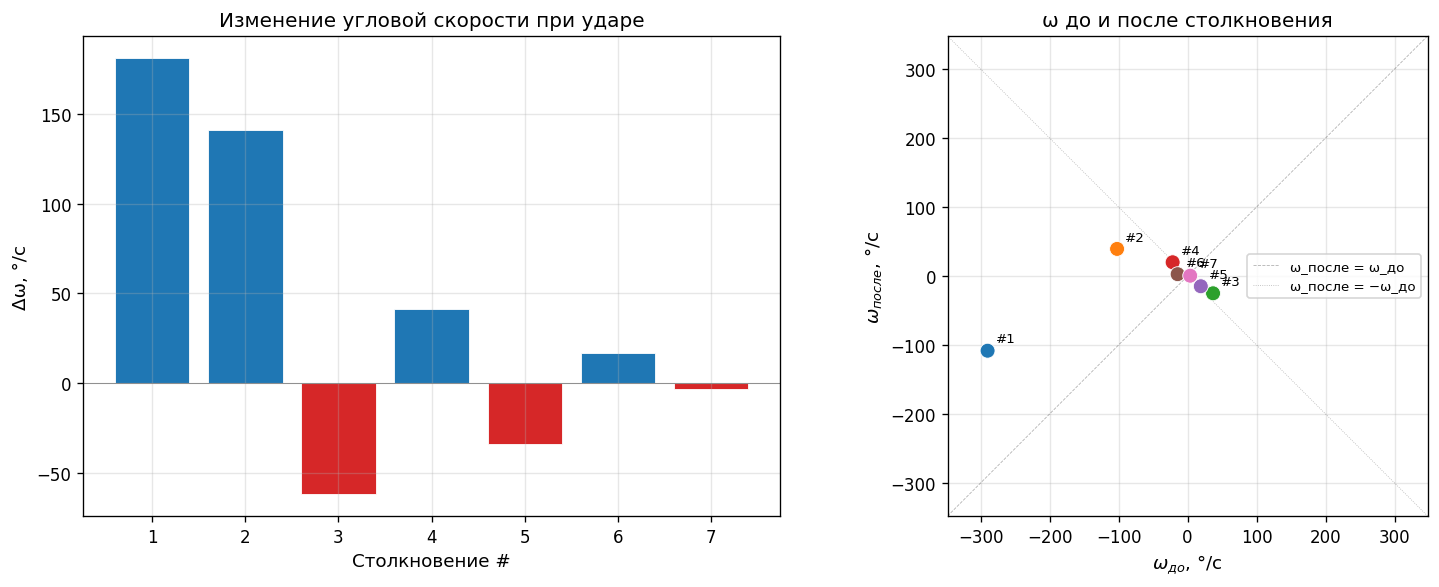

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Левый: Δω при каждом столкновении
ax = axes[0]
gz_before_list = []
gz_after_list = []
for i, grp in enumerate(collisions):
    b_s = max(0, grp[0] - 10)
    b_e = grp[0] - 1
    a_s = grp[-1] + 2
    a_e = min(len(df)-1, grp[-1] + 10)
    gz_b = np.mean(df.loc[b_s:b_e, 'gz_dps'])
    gz_a = np.mean(df.loc[a_s:a_e, 'gz_dps'])
    gz_before_list.append(gz_b)
    gz_after_list.append(gz_a)

delta_omega = np.array(gz_after_list) - np.array(gz_before_list)
colors = ['C0' if d > 0 else 'C3' for d in delta_omega]

x = np.arange(1, len(collisions)+1)
ax.bar(x, delta_omega, color=colors, edgecolor='white', lw=0.5)
ax.set_xlabel('Столкновение #')
ax.set_ylabel('Δω, °/с')
ax.set_title('Изменение угловой скорости при ударе')
ax.axhline(0, color='gray', lw=0.5)
ax.set_xticks(x)

# Правый: ω до vs ω после
ax = axes[1]
gb = np.array(gz_before_list)
ga = np.array(gz_after_list)
ax.scatter(gb, ga, s=80, zorder=5, c=[f'C{i%10}' for i in range(len(collisions))], 
           edgecolors='white', lw=0.5)
for i in range(len(collisions)):
    ax.annotate(f'#{i+1}', (gb[i], ga[i]), fontsize=8, xytext=(5, 5), textcoords='offset points')

lim = max(abs(gb).max(), abs(ga).max()) * 1.2
ax.plot([-lim, lim], [-lim, lim], 'k--', lw=0.5, alpha=0.3, label='ω_после = ω_до')
ax.plot([-lim, lim], [lim, -lim], 'k:', lw=0.5, alpha=0.3, label='ω_после = −ω_до')
ax.set_xlabel('$\omega_{до}$, °/с')
ax.set_ylabel('$\omega_{после}$, °/с')
ax.set_title('ω до и после столкновения')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_aspect('equal')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


**Наблюдения:**
- Большинство точек находятся в квадрантах II и IV (смена знака) — струна разворачивает вращение.
- Нет простой линейной связи $\omega_{после} = -e \cdot \omega_{до}$ — потери зависят от геометрии контакта.
- |Δω| уменьшается с каждым последующим столкновением вместе с |ω|.


## 7. Потери вращательной кинетической энергии

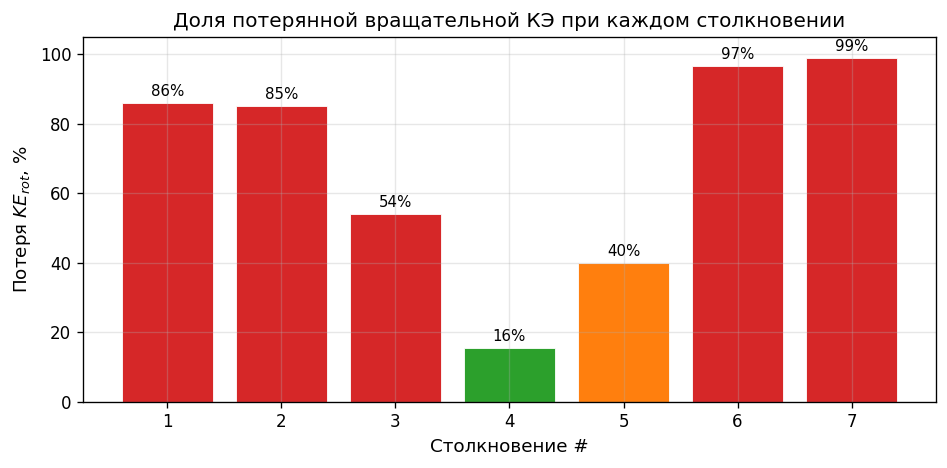

Потери сильно варьируются (16–98%) — нет единого коэффициента восстановления.
Это ожидаемо: исход столкновения зависит от точки контакта на ободе диска.


In [11]:
ke_loss = 1 - (np.array(gz_after_list)**2) / (np.array(gz_before_list)**2)

fig, ax = plt.subplots(figsize=(8, 4))
colors_ke = ['C3' if loss > 0.5 else 'C1' if loss > 0.2 else 'C2' for loss in ke_loss]
ax.bar(x, ke_loss * 100, color=colors_ke, edgecolor='white', lw=0.5)
ax.set_xlabel('Столкновение #')
ax.set_ylabel('Потеря $KE_{rot}$, %')
ax.set_title('Доля потерянной вращательной КЭ при каждом столкновении')
ax.set_xticks(x)
ax.set_ylim(0, 105)
for i, v in enumerate(ke_loss):
    ax.text(i+1, v*100 + 2, f'{v*100:.0f}%', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

print("Потери сильно варьируются (16–98%) — нет единого коэффициента восстановления.")
print("Это ожидаемо: исход столкновения зависит от точки контакта на ободе диска.")


## 8. Замедление поступательного движения

<>:25: SyntaxWarning: invalid escape sequence '\o'
<>:25: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_113/1865406962.py:25: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('$|\omega|$ после удара, °/с')


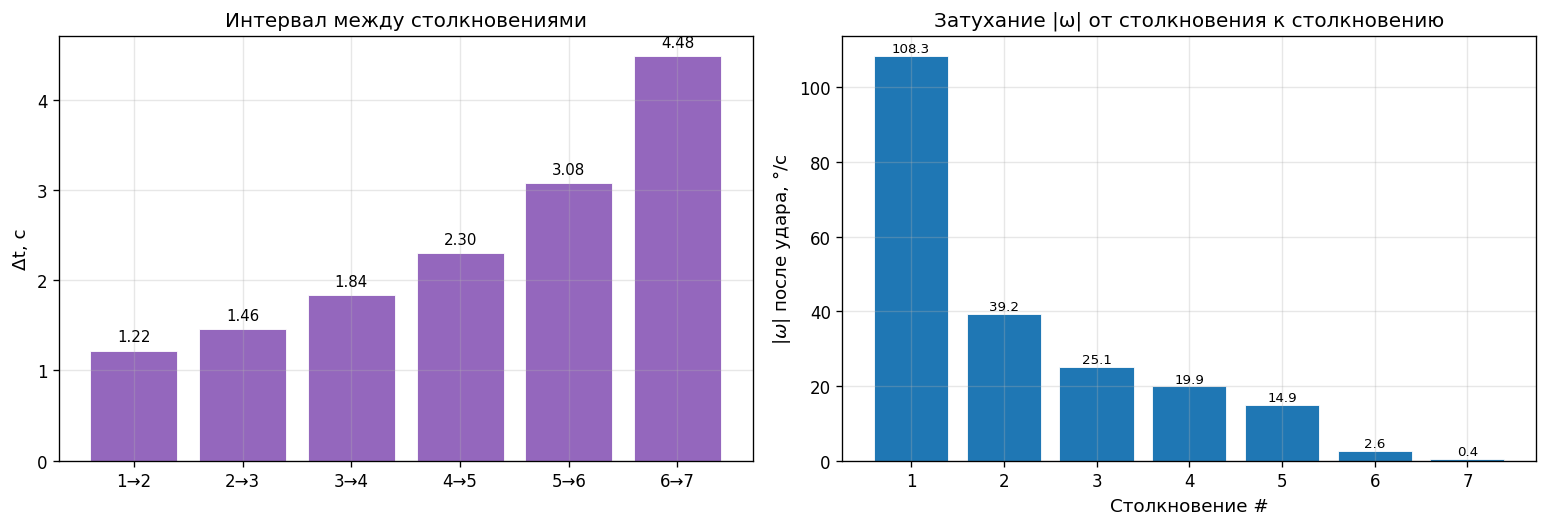

Интервалы: 1.22, 1.46, 1.84, 2.30, 3.08, 4.48 с
Рост интервалов ≈ в 3.7 раза → диск поступательно замедляется.


In [12]:
# Время столкновений и интервалы
collision_times = []
for grp in collisions:
    peak_idx = df.loc[grp, 'a_xy'].idxmax()
    collision_times.append(df.loc[peak_idx, 'time_s'])

dt_between = np.diff(collision_times)

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# Левый: интервалы между столкновениями
ax = axes[0]
labels = [f'{i+1}→{i+2}' for i in range(len(dt_between))]
ax.bar(labels, dt_between, color='C4', edgecolor='white', lw=0.5)
ax.set_ylabel('Δt, с')
ax.set_title('Интервал между столкновениями')
for i, v in enumerate(dt_between):
    ax.text(i, v + 0.1, f'{v:.2f}', ha='center', fontsize=9)

# Правый: |ω| после каждого столкновения
ax = axes[1]
omega_after_abs = [abs(g) for g in gz_after_list]
ax.bar(x, omega_after_abs, color='C0', edgecolor='white', lw=0.5)
ax.set_xlabel('Столкновение #')
ax.set_ylabel('$|\omega|$ после удара, °/с')
ax.set_title('Затухание |ω| от столкновения к столкновению')
for i, v in enumerate(omega_after_abs):
    ax.text(i+1, v + 1, f'{v:.1f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

print(f"Интервалы: {', '.join(f'{d:.2f}' for d in dt_between)} с")
print(f"Рост интервалов ≈ в {dt_between[-1]/dt_between[0]:.1f} раза → диск поступательно замедляется.")


Монотонный рост интервалов между столкновениями означает, что **линейная скорость диска уменьшается** — воздушная подушка обеспечивает вязкое торможение и поступательного движения.

Без данных о положении (только бортовой IMU) невозможно напрямую восстановить линейную скорость, но рост $\Delta t$ — надёжный косвенный индикатор.


## 9. Сводка количественных результатов

| Параметр | Значение | Комментарий |
|----------|---------|-------------|
| Модель трения вращения | $\alpha = -\omega / \tau$ | Чисто вязкое |
| Постоянная затухания τ | **17.1 с** | Кулоновская компонента ≈ 0 |
| Число столкновений | **7** | Запуск рукой исключён |
| Пиковые ускорения | 1.3 – 10.3 g | |
| Длительность контакта | ≤ 40 мс | Ограничена частотой 50 Гц |
| Смена знака ω при ударе | **5 из 7** | Тангенциальный импульс от струны |
| Потери $KE_{rot}$ при ударе | 16% – 98% | Зависят от геометрии контакта |
| Рост Δt между ударами | 1.22 → 4.48 с (×3.7) | Замедление поступательного движения |
| Чередование θ ударов | ~90° / ~−120° | Отскоки между двумя стенками |

### Что ещё можно извлечь при дополнительных данных:
- **С двумя IMU или внешней камерой:** восстановить линейную скорость → полный энергетический баланс (поступательная + вращательная КЭ).
- **С более высокой частотой дискретизации (≥ 1 кГц):** длительность контакта и форма импульса при столкновении.
- **С известной массой и моментом инерции:** абсолютные значения моментов сил, энергий и импульсов.
